<a href="https://colab.research.google.com/github/MominaSiddiq/AI_Generated_vs_HumanCreated_Sketches/blob/main/AI_vs_Human_sketches_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Training CNN Model From Scrach**

In [ ]:
# Imports

from google.colab import drive
from keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.applications import ResNet50
import collections
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import random
import shutil



### Fetch data
Fetching data from the drive in three folders (Splited Data): Test, Valid and Train  

In [ ]:
# Fetch dataset from the drive
drive.mount('/content/drive')

NameError: name 'drive' is not defined

In [ ]:
# Fetch the split data from the drive

train_dir = '/content/drive/MyDrive/sketch_classification_project/train'
valid_dir = '/content/drive/MyDrive/sketch_classification_project/valid'
test_dir = '/content/drive/MyDrive/sketch_classification_project/test'

In [ ]:
# Verify paths
for dir_path in [train_dir, valid_dir, test_dir]:
    if os.path.exists(dir_path):
        print(f"Directory exists: {dir_path}")
    else:
        print(f"Directory does not exist: {dir_path}")


NameError: name 'os' is not defined

In [ ]:
# Check .png files in source directories
for category in ['AI', 'Human']:
    for dir_path in [train_dir, valid_dir, test_dir]:
        full_path = os.path.join(dir_path, category)
        if os.path.exists(full_path):
            all_images = [img for img in os.listdir(full_path) if img.endswith(( '.jpg'))]
            print(f"{len(all_images)} images found in {full_path}")

In [ ]:
# Clear subset directories
def clear_directory(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)  # Delete the directory and its contents
    os.makedirs(directory, exist_ok=True)  # Recreate the directory

# Clear subset directories
clear_directory(subset_train_dir + '/AI')
clear_directory(subset_train_dir + '/Human')
clear_directory(subset_valid_dir + '/AI')
clear_directory(subset_valid_dir + '/Human')
clear_directory(subset_test_dir + '/AI')
clear_directory(subset_test_dir + '/Human')

In [ ]:
# Function to copy a subset of images
def copy_subset(src_dir, dest_dir, num_images):
    for category in ['AI', 'Human']:
        src_category_dir = os.path.join(src_dir, category)
        dest_category_dir = os.path.join(dest_dir, category)

        # Filter only .png files
        all_images = [img for img in os.listdir(src_category_dir) if img.endswith('.jpg')]
        print(f"Found {len(all_images)} .jpg images in {src_category_dir}")

        # Ensure there are enough images to sample
        if len(all_images) < num_images:
            print(f"Not enough images in {src_category_dir}. Needed: {num_images}, Found: {len(all_images)}")
            num_images = len(all_images)  # Adjust to the available images

        # Randomly select images and copy
        selected_images = random.sample(all_images, num_images)
        for img in selected_images:
            print(f"Copying {img} to {dest_category_dir}")
            shutil.copy2(os.path.join(src_category_dir, img), os.path.join(dest_category_dir, img))


In [ ]:
# Paths for new subset directories
subset_dir = '/content/drive/MyDrive/sketch_classification_project_subset'
subset_train_dir = os.path.join(subset_dir, 'train')
subset_valid_dir = os.path.join(subset_dir, 'valid')
subset_test_dir = os.path.join(subset_dir, 'test')

# Create new directories for subset
os.makedirs(subset_train_dir + '/AI', exist_ok=True)
os.makedirs(subset_train_dir + '/Human', exist_ok=True)
os.makedirs(subset_valid_dir + '/AI', exist_ok=True)
os.makedirs(subset_valid_dir + '/Human', exist_ok=True)
os.makedirs(subset_test_dir + '/AI', exist_ok=True)
os.makedirs(subset_test_dir + '/Human', exist_ok=True)

In [ ]:
# Copy subset of images
total_image_to_process = 1000
train_images = 400
copy_subset(train_dir, subset_train_dir, 400)  # 400 per class for training
copy_subset(valid_dir, subset_valid_dir, 50)   # 50 per class for validation
copy_subset(test_dir, subset_test_dir, 50)    # 50 per class for testing

In [ ]:
# Check subset directory contents
for category in ['AI', 'Human']:
    for subset_dir in [subset_train_dir, subset_valid_dir, subset_test_dir]:
        subset_category_dir = os.path.join(subset_dir, category)
        print(f"{len(os.listdir(subset_category_dir))} images in {subset_category_dir}")

In [ ]:
# Update directories
subset_train_dir = '/content/drive/MyDrive/sketch_classification_project_subset/train'
subset_valid_dir = '/content/drive/MyDrive/sketch_classification_project_subset/valid'
subset_test_dir = '/content/drive/MyDrive/sketch_classification_project_subset/test'


### Data Augmentation

Doing the augmentation of the training data by rotating, rescaling, fliping, and shifting width and height.



In [ ]:
# Data augmentation for training data
train_datagen = image_dataset_from_directory(
    rescale=1./255,         # Normalize pixel values
    rotation_range=20,      # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2, # Randomly shift images vertically
    shear_range=0.2,        # Randomly shear images
    zoom_range=0.2,         # Randomly zoom into images
    horizontal_flip=True    # Randomly flip images horizontally
)

# No augmentation for validation and test data
valid_datagen = image_dataset_from_directory(rescale=1./255)
test_datagen = image_dataset_from_directory(rescale=1./255)

# Load training data with augmentation
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),  # Resize images to 128x128
    batch_size=32,
    class_mode='binary'      # Binary classification: AI vs Human
)

# Load validation data without augmentation
valid_data = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

# Load test data without augmentation
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

TypeError: image_dataset_from_directory() got an unexpected keyword argument 'rescale'

### Pre-processing
Pre-processing of this images data include:


*   Re-sizing of images for efficient training.

*   Setting the batch size to 32 optimizes memory usage and speeds up training.



In [ ]:
# Load training data
train_data = image_dataset_from_directory(
    subset_train_dir,
    image_size=(128, 128),  # Resize images to 128x128
    batch_size=32,          # Process in batches of 32
    label_mode='binary'     # Binary classification: AI vs Human
)

# Load validation data
valid_data = image_dataset_from_directory(
    subset_valid_dir,
    image_size=(128, 128),
    batch_size=32,
    label_mode='binary'
)

# Load test data
test_data = image_dataset_from_directory(
    subset_test_dir,
    image_size=(128, 128),
    batch_size=32,
    label_mode='binary'
)

Found 800 files belonging to 2 classes.
Found 100 files belonging to 2 classes.
Found 100 files belonging to 2 classes.


### Defining & Compiling CNN Model
Define and compile a basic CNN model for binary classification

1. Tried it by adding a dropout layer of 0.25.

In [ ]:
# Define the updated CNN model
model = Sequential([
    # Data augmentation (can also be done externally)
    tf.keras.layers.Input(shape=(128, 128, 3)),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),

    # CNN layers with Batch Normalization and Dropout
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.4),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.4),

    Flatten(),

    # Fully connected layers
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Adjust optimizer if needed
    loss='binary_crossentropy',
    metrics=['accuracy']
)
# Model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_4 (RandomFlip)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_4 (RandomRotation)   │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_4 (RandomZoom)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,750,145 (10.49 MB)

 Trainable params: 2,749,185 (10.49 MB)

 Non-trainable params: 960 (3.75 KB)

### Training CNN Model
Train the model on the training data and validate on the validation set.

In [ ]:
# Callbacks
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=50,
    callbacks=[lr_schedule, early_stopping]
)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.5465 - loss: 2.7889 - val_accuracy: 0.5200 - val_loss: 4.3339 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.5326 - loss: 1.6793 - val_accuracy: 0.5100 - val_loss: 2.5587 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.5559 - loss: 0.9322 - val_accuracy: 0.5200 - val_loss: 0.7802 - learning_rate: 0.0010
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.6028 - loss: 0.7012 - val_accuracy: 0.4900 - val_loss: 0.8807 - learning_rate: 0.0010
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.6256 - loss: 0.6988 - val_accuracy: 0.5000 - val_loss: 1.8019 - learning_rate: 0.0010
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6325 - loss: 0.6764
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
25/25 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.6312 - loss: 0.6766 - val_accuracy: 0.

### Visualizing
To monitor the model's performance over time, plot the training and validation accuracy and loss.

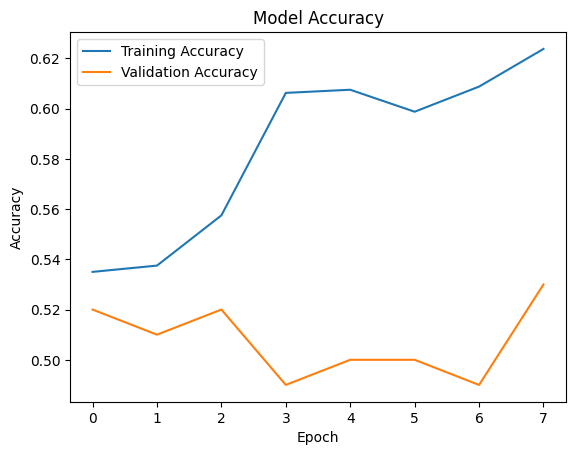

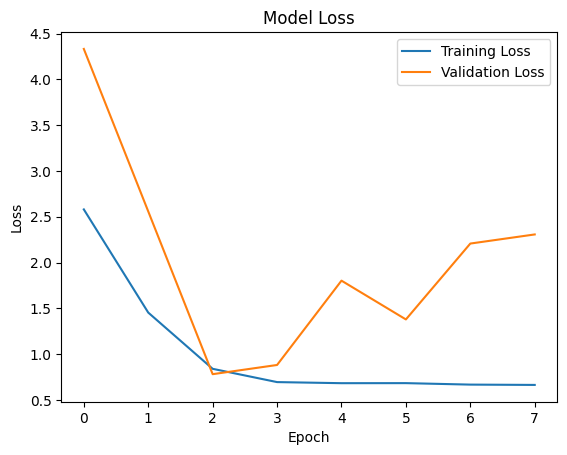

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


<ipython-input-49-77dc0fb4c9cb>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_label = class_names[int(predicted_labels[i])]


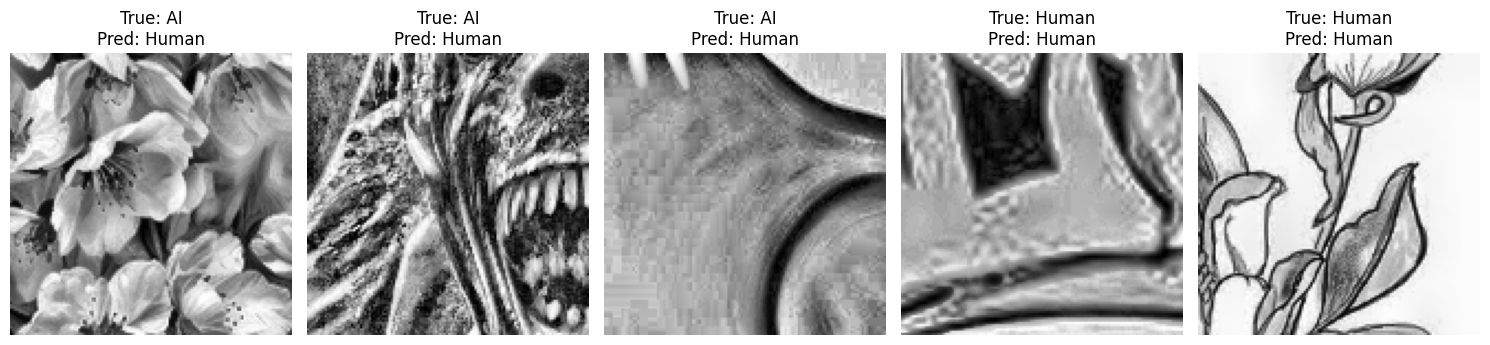

In [ ]:
# Function to visualize predictions
def visualize_predictions(model, dataset, class_names, num_images=5):
    """
    Display a few images from the dataset along with their predicted labels.

    Args:
        model: Trained model for making predictions.
        dataset: Dataset (e.g., test_data) to pull images from.
        class_names: List of class names corresponding to labels (e.g., ['AI', 'Human']).
        num_images: Number of images to display.
    """
    # Get a batch of images and labels
    images, labels = next(iter(dataset))

    # Make predictions
    predictions = model.predict(images[:num_images])

    # Convert predictions to class labels
    predicted_labels = (predictions > 0.5).astype("int32")  # Threshold for binary classification

    # Display the images with predicted labels
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(array_to_img(images[i]))
        true_label = class_names[int(labels[i])]
        predicted_label = class_names[int(predicted_labels[i])]
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Class names
class_names = ['AI', 'Human']  # Modify based on your dataset

# Call the function on test_data
visualize_predictions(model, test_data, class_names)



# Transfer Learning
Doing it with transfer learning technique by using ResNet50 and VGG16 and analyze the results.




## ResNet Model


### Load Dataset
Loading train and validation datasets.